## Trabalho Final - Baseado em Processamento de Linguagem Natural

* A base de dados contém os posts de usuários de twitter, visa analisar o comportamente do usuário da rede social através de suas postagens e classifica-los como positivos, negativos e neutros.

* Este presente trabalho apresenta a etapa de extração dos dados, análise sentimental através do método NLP, e por fim, utilizamos o modelo neural SOM para agrupar os dados e tomar as conclusões.

### Referências
- Base de dados:
https://twitter.com/

- Código de referência:
https://github.com/allysonliveira/MACHINE-LEARNING-TRABALHO-FINAL
https://colab.research.google.com/drive/1kqgBELk-QMU9hP13sjd75kZbLn-LeCrw?usp=sharing


In [ ]:
##ETAPA DE EXTRAÇÃO DE DADOS
#Implementação da mineração das mensagens dos usuários do tweet e para criação de um arquivo .csv

!pip install snscrape
!pip install tweepy

import tweepy
import snscrape.modules.twitter as sntwitter
import pandas as pd


In [ ]:
# passa o Consumer Key e o Consumer Secret
auth = tweepy.OAuthHandler('', '')
# define o token de acesso
# passa o "Access Token" e o "Access Token Secret"
auth.set_access_token('',	'')

# cria um objeto api
api = tweepy.API(auth)


# obtém tweets de um usuário
def obter_tweets(usuario, limite=500):
	resultados = api.user_timeline(screen_name=usuario, count=limite, tweet_mode='extended')
	tweets = [] # lista de tweets inicialmente vazia
	for r in resultados:
		# utiliza expressão regular para remover a URL do tweet
		# http pega o início da url
		# \S+ pega os caracteres não brancos (o final da URL)
		tweet = re.sub(r'http\S+', '', r.full_text)
		tweets.append(tweet.replace('\n', ' ')) # adiciona na lista
	return tweets # retorna a lista de tweets

#Os endereços dos usuários desejados. exemplo: @tweeter, copia apenas o 'tweeter'
usuarios = ['LulaOficial', 'jairbolsonaro', 'CNNBrasil','GloboNews', 'folha']
tweets = []
#Para cada usuário obtém os tweets e armazena na lista tweets.
for u in usuarios:
  aux = obter_tweets(usuario=u , limite=500)
  len(aux)
  for t in aux:
    tweets.append(t)

#Cria uma variável panda
tw = pd.DataFrame({'Tweets' : tweets})

#Salva os tweets em um formato csv
tw.to_csv("tweets_brutos.csv")

In [23]:
##ETAPA DE APLICAÇÃO DO MODELO DE LINGUAGEM NATURAL

import nltk
import pandas as pd

from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

nltk.download('subjectivity')
nltk.download('vader_lexicon')

n_instances = 1000
subj_docs = [(sent, 'subj') for sent in subjectivity.sents(categories='subj')[:n_instances]]
obj_docs = [(sent, 'obj') for sent in subjectivity.sents(categories='obj')[:n_instances]]

[nltk_data] Downloading package subjectivity to /root/nltk_data...
[nltk_data]   Package subjectivity is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [25]:
train_subj_docs = subj_docs[:80]
test_subj_docs = subj_docs[80:100]
train_obj_docs = obj_docs[:80]
test_obj_docs = obj_docs[80:100]
training_docs = train_subj_docs+train_obj_docs
testing_docs = test_subj_docs+test_obj_docs
sentim_analyzer = SentimentAnalyzer()
all_words_neg = sentim_analyzer.all_words([mark_negation(doc) for doc in training_docs])

unigram_feats = sentim_analyzer.unigram_word_feats(all_words_neg, min_freq=4)
len(unigram_feats)

sentim_analyzer.add_feat_extractor(extract_unigram_feats, unigrams=unigram_feats)

training_set = sentim_analyzer.apply_features(training_docs)
test_set = sentim_analyzer.apply_features(testing_docs)

trainer = NaiveBayesClassifier.train
classifier = sentim_analyzer.train(trainer, training_set)

for key,value in sorted(sentim_analyzer.evaluate(test_set).items()):
  print('{0}: {1}'.format(key, value))

Training classifier
Evaluating NaiveBayesClassifier results...
Accuracy: 0.8
F-measure [obj]: 0.8
F-measure [subj]: 0.8
Precision [obj]: 0.8
Precision [subj]: 0.8
Recall [obj]: 0.8
Recall [subj]: 0.8


In [77]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

dataset = pd.read_csv("https://raw.githubusercontent.com/allysonliveira/MACHINE-LEARNING-TRABALHO-FINAL/main/database/tweets_brutos.csv")
sentences = dataset

In [33]:
sid = SentimentIntensityAnalyzer()

compo = []
negative = []
neutro = []
pos = []

# Monta os dados para gerar o csv
for sentence in sentences:
    ss = sid.polarity_scores(sentence)
    compo.append(ss["compound"])
    negative.append(ss["neg"])
    neutro.append(ss["neu"])
    pos.append(ss["pos"])

# Verifica se todas as listas têm o mesmo comprimento
if len(compo) == len(negative) == len(neutro) == len(pos) == len(sentences):
    # Cria o DataFrame
    tweets_categorizados = pd.DataFrame({'tweets': sentences, 'compound': compo, 'negativos': negative, 'neutro': neutro, 'positivo': pos})
    tweets_categorizados.to_csv("tweets_categorizados.csv", index=False)
else:
    print("As listas não têm o mesmo comprimento.")


As listas não têm o mesmo comprimento.


In [32]:
##ETAPA DE APLICAÇÃO DO MODELO SOM

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#instalando o MiniSOM
# https://github.com/JustGlowing/minisom
!pip install minisom

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.1-py3-none-any.whl size=10589 sha256=d53bf79b324502fd3de349d02a14f03d8bb63aa23029d5288037d7956dc330b2
  Stored in directory: /root/.cache/pip/wheels/c7/92/d2/33bbda5f86fd8830510b16aa98c8dd420129b5cb24248fd6db
Successfully built minisom


In [78]:
#Lendo a base de dados
dataset = pd.read_csv('https://raw.githubusercontent.com/allysonliveira/MACHINE-LEARNING-TRABALHO-FINAL/main/database/tweets_categorizados.csv')

dataset.head( 10 )

,Unnamed: 0,tweets,compound,negativos,neutro,positivo
0,0,"""teste""",0.0000,0.000,1.000,0.000
1,1,RT @WhiteHouse: LIVE: President @realDonaldTru...,0.2960,0.000,0.804,0.196
2,2,"...love to have Mike Pompeo, Rick Perry, Mick ...",-0.7177,0.140,0.860,0.000
3,3,...lawyer has already stated that I did nothin...,0.3724,0.000,0.943,0.057
4,4,The D.C. Wolves and Fake News Media are readin...,-0.7269,0.165,0.787,0.048
5,5,RT @DailyCaller: President @realDonaldTrump si...,0.0000,0.000,1.000,0.000
6,6,RT @DailyCaller: Adam Schiff Challenger Jennif...,-0.6249,0.242,0.693,0.065
7,7,RT @DailyCaller: The Tide Is Turning Against D...,0.0000,0.000,1.000,0.000
8,8,RT @DailyCaller: Poll: Independents Flip On Im...,0.0000,0.000,1.000,0.000
9,9,When the Military rips down an old &amp; badly...,0.3707,0.100,0.759,0.141


In [81]:
#coleta de dados necessários tabelados acima
X = dataset.iloc[:,[2,3,4,5]].values


#tamanho da rede
tx = 4
ty = 4

#treinamento do modelo SOM
from minisom import MiniSom
som = MiniSom(x = tx, y = ty, input_len = 4, sigma = 1.0, learning_rate = 0.5)
som.random_weights_init(X)
som.train_random(data = X, num_iteration = 1000)

#contagem dos negativos, neutros e positivo
negativo = [-0.6229, 1., 0., 0.] #Frase: BAD!!
neutro   = [0., 0., 1., 0.]
positivo = [0.6467, 0., 0., 1.] #Frase: HAPPY!!

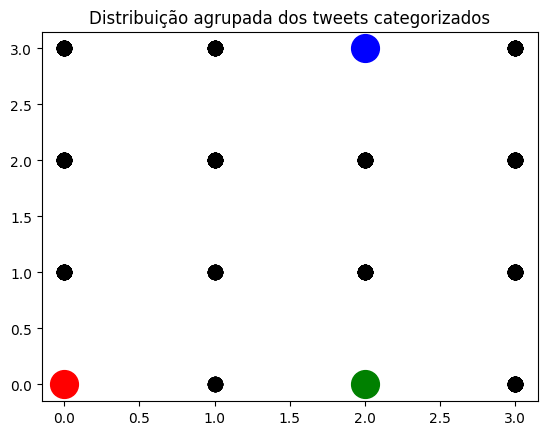

In [83]:
#PLOTAGEM DO GRÁFICO

import matplotlib
import matplotlib.pyplot as plt

# matriz de zeros para o contador de totais
MT = np.zeros((tx,ty))

fig, ax = plt.subplots()
ax.set_title('Distribuição agrupada dos tweets categorizados')

for i in X:
  pos = som.winner(i)
  ax.plot(pos[0], pos[1], 'o' ,color="black", markersize=10)
  MT[pos] += 1

#plota um teeter 100% Positivo
pos = som.winner(positivo)
ax.plot(pos[0], pos[1], 'o' ,color="green", markersize=20)

#plota um tweeter 100% negativo
pos = som.winner(negativo)
ax.plot(pos[0], pos[1], 'o' ,color="red", markersize=20)

#plota um tweeter 100% neutro
pos = som.winner(neutro)
ax.plot(pos[0], pos[1], 'o' ,color="blue", markersize=20 )

plt.show()

In [84]:
print("Total:")
print(MT)

Total:
[[ 18.  80.  91.  98.]
 [ 17.  22.  48.  38.]
 [ 27.  43.  87. 265.]
 [105. 113.  99.  48.]]


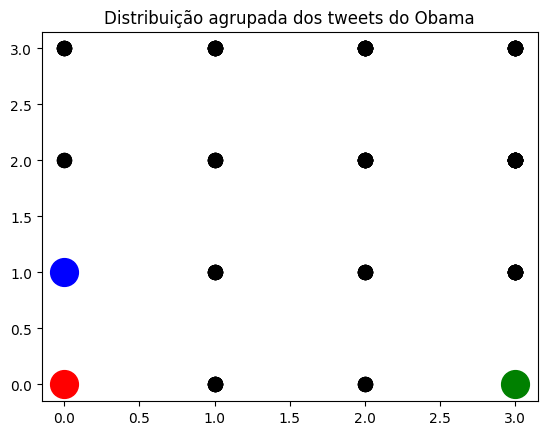

In [85]:
##ANALISES INDIVIDUAIS
#dataset = pd.read_csv('https://raw.githubusercontent.com/alyssonolima/Projeto-Virtual-Mood-Identifier/master/Dados/tweets_Donald_Trump_categorizados.csv')
dataset = pd.read_csv('https://raw.githubusercontent.com/alyssonolima/Projeto-Virtual-Mood-Identifier/master/Dados/tweets_Barack_Obama_categorizados.csv')

#coleta de dados necessários tabelados acima
X = dataset.iloc[:,[2,3,4,5]].values

#tamanho da rede
tx = 4
ty = 4

#treinamento do modelo SOM
from minisom import MiniSom
som = MiniSom(x = tx, y = ty, input_len = 4, sigma = 1.0, learning_rate = 0.5)
som.random_weights_init(X)
som.train_random(data = X, num_iteration = 1000)

fig, ax = plt.subplots()
ax.set_title('Distribuição agrupada dos tweets do Obama')

for i in X:
  pos = som.winner(i)
  ax.plot(pos[0], pos[1], 'o' ,color="black", markersize=10)
  MT[pos] += 1

#plota um teeter 100% Positivo
pos = som.winner(positivo)
ax.plot(pos[0], pos[1], 'o' ,color="green", markersize=20)

#plota um tweeter 100% negativo
pos = som.winner(negativo)
ax.plot(pos[0], pos[1], 'o' ,color="red", markersize=20)

#plota um tweeter 100% neutro
pos = som.winner(neutro)
ax.plot(pos[0], pos[1], 'o' ,color="blue", markersize=20 )

plt.show()